<a href="https://colab.research.google.com/github/DanielhCarranza/Machine-Learning-in-Health/blob/master/Age_Macular_Degeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age-related Macular Degeneration Detection

## Clinical Background

Age-related macular degeneration, abbreviated as AMD, is a degenerative disorder in the macular region. It mainly occurs in people older than 45 years old and its incidence rate is even higher than diabetic retinopathy in the elderly.  

The etiology of AMD is not fully understood, which could be related to multiple factors, including genetics, chronic photodestruction effect, and nutritional disorder. AMD is classified into Dry AMD and Wet AMD. Dry AMD (also called nonexudative AMD) is not neovascular. It is characterized by progressive atrophy of retinal pigment epithelium (RPE). In the late stage, drusen and the large area of atrophy could be observed under ophthalmoscopy. Wet AMD (also called neovascular or exudative AMD), is characterized by active neovascularization under RPE, subsequently causing exudation, hemorrhage, and scarring, and will eventually cause irreversible damage to the photoreceptors and rapid vision loss if left untreated.

An early diagnosis of AMD is crucial to treatment and prognosis. Fundus photo is one of the basic examinations. The current dataset is composed of AMD and non-AMD (myopia, normal control, etc.) photos. Typical signs of AMD that can be found in these photos include drusen, exudation, hemorrhage, etc. 

![fsf](https://refuge.grand-challenge.org/media/i/d63e0caf.jpg)
![dfg](https://refuge.grand-challenge.org/media/i/7c520308.png)





**Resources**:
* [Challenge](https://amd.grand-challenge.org/Home/)

### Setup

In [ ]:
# Training
! curl -L https://www.dropbox.com/s/mdx13ya26ut2msx/iChallenge-AMD-Training400.zip?dl=1 > iChallenge-AMD-Training400.zip
! curl -L https://www.dropbox.com/s/yi8ti5zd99a5ys8/iChallenge-AMD-Training400-Lesion.zip?dl=1 > iChallenge-AMD-Training400-Lesion.zip
! curl -L https://www.dropbox.com/s/qh5leqcxwu99wwk/DF-Annotation-Training400.zip?dl=1 > DF-Annotation-Training400.zip

In [ ]:
! mkdir AMD_Data
! mkdir AMD_Data/DF
! unzip iChallenge-AMD-Training400.zip -d AMD_Data
! unzip iChallenge-AMD-Training400-Lesion.zip  -d AMD_Data
! unzip DF-Annotation-Training400.zip -d AMD_Data/DF

## EDA

In [ ]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.vision.interpret import SegmentationInterpretation

import os
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc,roc_curve
from sklearn.metrics import classification_report

In [ ]:
path = Path('AMD_Data')

In [ ]:
train_path =    (path/'Training400')
ann_train_path= (path/'Training400-Lesion/Lesion_Masks')

path.ls()

[PosixPath('AMD_Data/DF'),
 PosixPath('AMD_Data/__MACOSX'),
 PosixPath('AMD_Data/Training400'),
 PosixPath('AMD_Data/Training400-Lesion')]

In [ ]:
ann_train_path.ls()

[PosixPath('AMD_Data/Training400-Lesion/Lesion_Masks/others'),
 PosixPath('AMD_Data/Training400-Lesion/Lesion_Masks/.DS_Store'),
 PosixPath('AMD_Data/Training400-Lesion/Lesion_Masks/hemorrhage'),
 PosixPath('AMD_Data/Training400-Lesion/Lesion_Masks/scar'),
 PosixPath('AMD_Data/Training400-Lesion/Lesion_Masks/drusen'),
 PosixPath('AMD_Data/Training400-Lesion/Lesion_Masks/exudate')]

In [ ]:
mask_f=(ann_train_path/'Lesion_Masks/scar').ls()[0]
mask = open_mask(mask_f)
print(mask.shape)


torch.Size([1, 1444, 1444])


In [ ]:
train_path.ls()

[PosixPath('AMD_Data/Training400/Non-AMD'),
 PosixPath('AMD_Data/Training400/AMD'),
 PosixPath('AMD_Data/Training400/models')]

In [ ]:
len((train_path/'Non-AMD').ls()),len((train_path/'AMD').ls()) 

(311, 89)

In [ ]:
img = open_image((train_path/'AMD').ls()[0])
print(img.shape)



torch.Size([3, 2056, 2124])


In [ ]:
disk_masks_path = (path/'DF/Training400/Disc_Masks')
len(disk_masks_path.ls())

400

# Classification

In [ ]:
classes= ['Non-AMD','AMD']
get_labels = lambda x: x.parts[-2]

src = (ImageList.from_folder(train_path)
       .split_by_rand_pct()
       .label_from_func(get_labels, classes=classes))

def get_data(bs, sz):
  return (src.transform(get_transforms(flip_vert=True), size=sz)
          .databunch(bs= bs, num_workers=4)
          .normalize(imagenet_stats))

In [ ]:
%time data= get_data(64,224)

CPU times: user 9.92 s, sys: 150 ms, total: 10.1 s
Wall time: 10.2 s


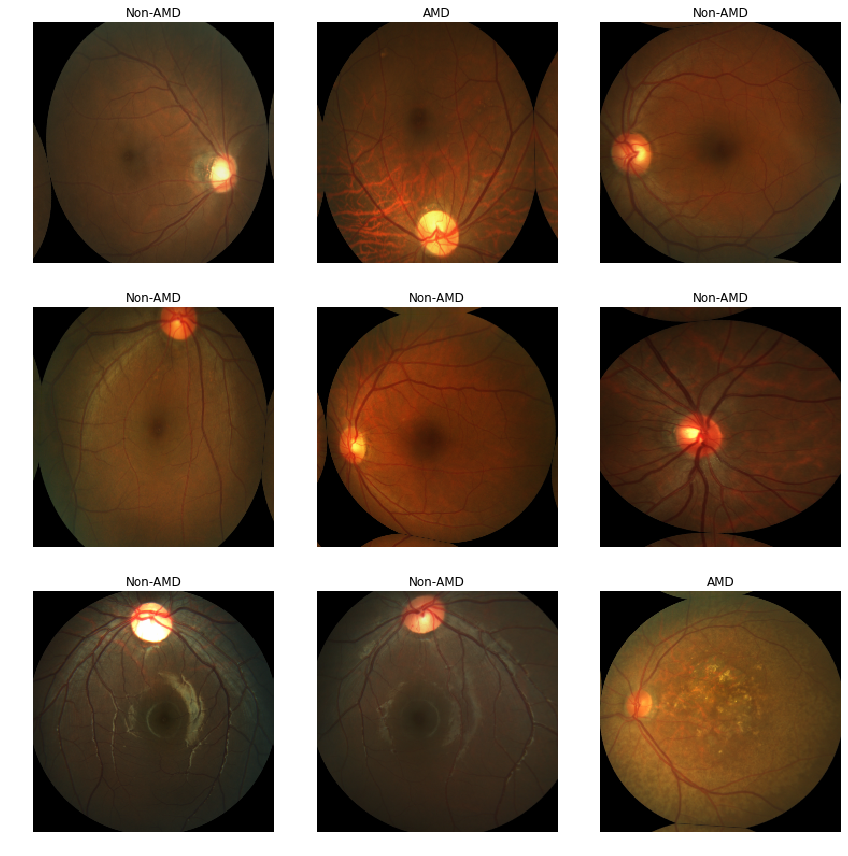

In [ ]:
data.show_batch(rows=3)

## Training

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='res50_224'),
        ShowGraph]

In [ ]:
learner= cnn_learner(data, models.resnet50, metrics= [accuracy], callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 98295161.13it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


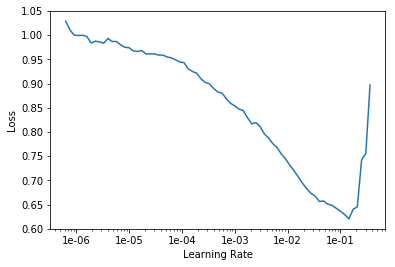

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.913601,0.402022,0.825000,00:47
1,0.796497,0.403036,0.800000,00:46
2,0.705012,0.426579,0.787500,00:45
3,0.602276,0.506294,0.862500,00:45
4,0.515365,0.401476,0.850000,00:45
5,0.449514,0.499616,0.825000,00:45
6,0.402900,0.526067,0.862500,00:45
7,0.354652,0.481420,0.875000,00:46
8,0.320097,0.506890,0.887500,00:45
9,0.293937,0.481283,0.875000,00:45


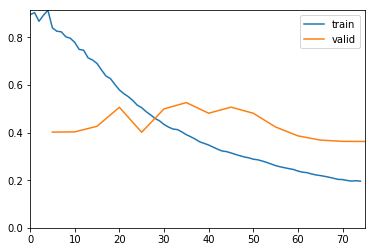

Epoch 1: reducing lr to 0.0009033777552576463
Epoch 2: reducing lr to 0.0015590151847573739
Epoch 3: reducing lr to 0.001961113254669918
Epoch 5: reducing lr to 0.001889657532366384
Epoch 6: reducing lr to 0.0017175083870153035
Epoch 7: reducing lr to 0.0014827942715619344
Epoch 8: reducing lr to 0.0012059817948266239
Epoch 9: reducing lr to 0.0009112084598606468
Epoch 10: reducing lr to 0.0006241779211960907


In [ ]:
lr= 1e-1
learner.fit_one_cycle(20, slice(1e-3,1e-2, lr))

In [ ]:
learner.save('res50_224_classification-90acc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


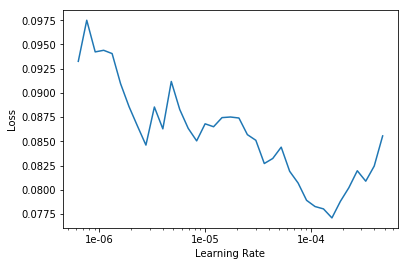

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.056762,0.366219,0.887500,00:46
1,0.067834,0.372992,0.887500,00:46
2,0.065021,0.376160,0.900000,00:46
3,0.065996,0.383642,0.887500,00:46
4,0.062776,0.411659,0.875000,00:46
5,0.062322,0.433319,0.900000,00:46
6,0.062512,0.458122,0.900000,00:46
7,0.060402,0.449489,0.912500,00:46
8,0.058810,0.445631,0.887500,00:46
9,0.056822,0.452968,0.887500,00:45


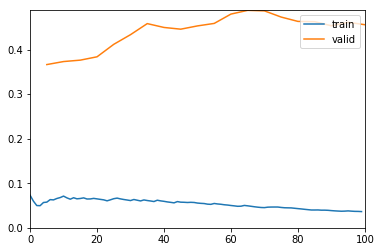

Epoch 1: reducing lr to 5.600000000000004e-06
Epoch 2: reducing lr to 1.0400000000000004e-05
Epoch 3: reducing lr to 1.5200000000000004e-05
Epoch 4: reducing lr to 1.871384387633062e-05
Epoch 5: reducing lr to 2.000000000000001e-05
Epoch 6: reducing lr to 1.9749280124701755e-05
Epoch 7: reducing lr to 1.900969264026948e-05
Epoch 8: reducing lr to 1.7818323551421008e-05
Epoch 9: reducing lr to 1.623491307899527e-05
Epoch 10: reducing lr to 1.433886003582602e-05
Epoch 11: reducing lr to 1.222524043872579e-05
Epoch 12: reducing lr to 1.0000040000000004e-05
Epoch 13: reducing lr to 7.774839561274218e-06
Epoch 14: reducing lr to 5.661219964173987e-06
Epoch 15: reducing lr to 3.7651669210047406e-06
Epoch 16: reducing lr to 2.1817564485790012e-06
Epoch 17: reducing lr to 9.903873597305262e-07
Epoch 18: reducing lr to 2.5079987529825117e-07
Epoch 19: reducing lr to 8.000000000000003e-11


In [ ]:
lr= 1e-4
learner.fit_one_cycle(20, slice(1e-5, lr))

### 512

In [ ]:
data512=get_data(24,512)

In [ ]:
learner= cnn_learner(data512, models.resnet50, metrics= [accuracy], callback_fns=cbfs).load('res50_224_classification-90acc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


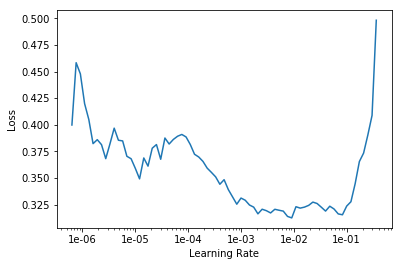

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.319100,0.496984,0.887500,01:10
1,0.218727,0.392885,0.900000,01:07
2,0.209188,0.410987,0.850000,01:06
3,0.206757,0.559600,0.862500,01:06
4,0.193572,0.408815,0.887500,01:06
5,0.182796,0.580704,0.762500,01:06
6,0.185271,0.421526,0.900000,01:06
7,0.174124,0.724125,0.887500,01:06
8,0.161218,0.582643,0.862500,01:05
9,0.161366,0.703269,0.887500,01:05


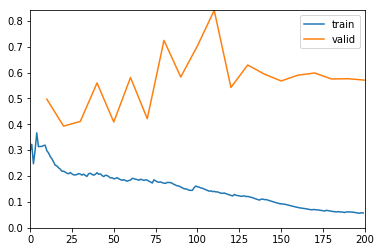

Epoch 2: reducing lr to 0.0010400000000000001
Epoch 3: reducing lr to 0.0015200000000000003
Epoch 4: reducing lr to 0.0018713843876330617
Epoch 5: reducing lr to 0.0020000000000000005
Epoch 6: reducing lr to 0.001974928012470175
Epoch 7: reducing lr to 0.0019009692640269478
Epoch 8: reducing lr to 0.0017818323551421003
Epoch 9: reducing lr to 0.0016234913078995265
Epoch 10: reducing lr to 0.001433886003582602
Epoch 11: reducing lr to 0.0012225240438725788
Epoch 12: reducing lr to 0.0010000040000000003
Epoch 13: reducing lr to 0.0007774839561274217
Epoch 14: reducing lr to 0.0005661219964173986
Epoch 15: reducing lr to 0.00037651669210047407
Epoch 16: reducing lr to 0.00021817564485790013
Epoch 17: reducing lr to 9.90387359730526e-05
Epoch 18: reducing lr to 2.5079987529825117e-05
Epoch 19: reducing lr to 8.000000000000002e-09


In [ ]:
learner.fit_one_cycle(20, slice(1e-3,1e-2))

In [ ]:
learner.save('res50_224_classification-91acc')

In [ ]:
learner.load('res50_224_classification-91acc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


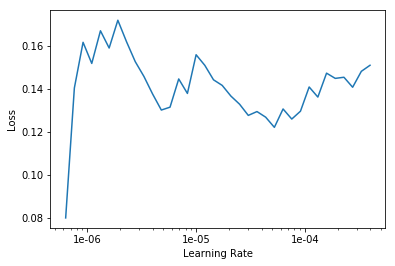

In [ ]:
learner.to_fp16()
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.165050,0.159922,0.987500,01:07
1,0.162620,0.164496,0.987500,01:04
2,0.123192,0.166678,0.987500,01:03
3,0.119291,0.186626,0.987500,01:03


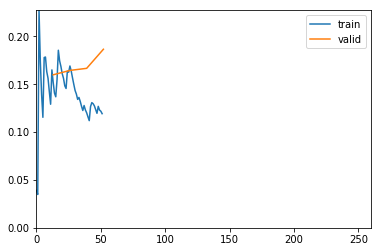

Epoch 1: reducing lr to 5.600000000000004e-06
Epoch 2: reducing lr to 1.0400000000000004e-05
Epoch 3: reducing lr to 1.5200000000000004e-05


KeyboardInterrupt: ignored

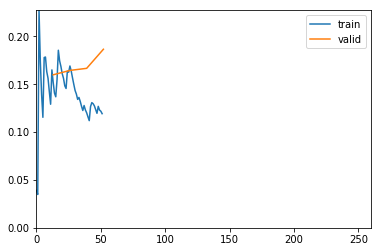

In [ ]:
lr= 1e-4
learner.fit_one_cycle(20, slice(1e-5, lr))

In [ ]:
learner.save('res50_512_classification-985acc')

## Evaluation

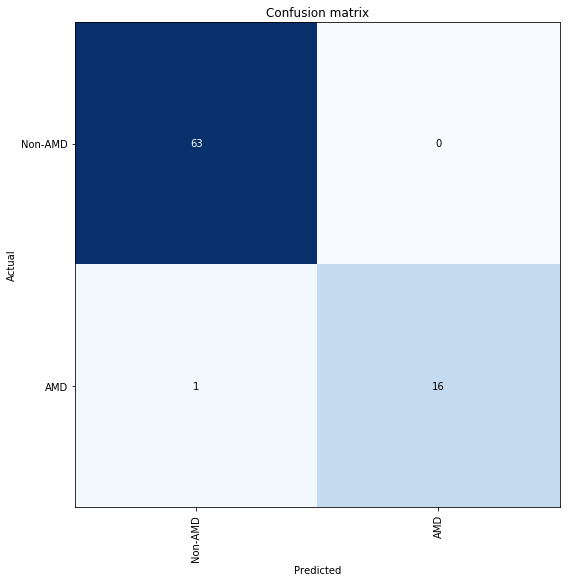

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
# Predictions of the validation data
preds, y_true=learner.get_preds()
y_true.shape, preds.shape

(torch.Size([80]), torch.Size([80, 2]))

In [ ]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((80,), (80,))

In [ ]:
# Generate a classification report
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

     Non-AMD       0.98      1.00      0.99        63
         AMD       1.00      0.94      0.97        17

    accuracy                           0.99        80
   macro avg       0.99      0.97      0.98        80
weighted avg       0.99      0.99      0.99        80



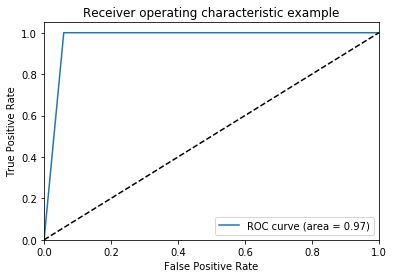

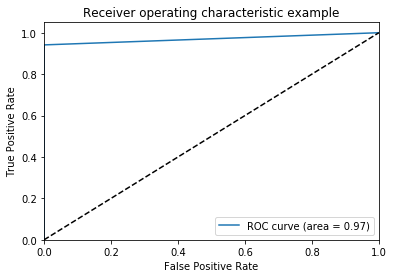

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

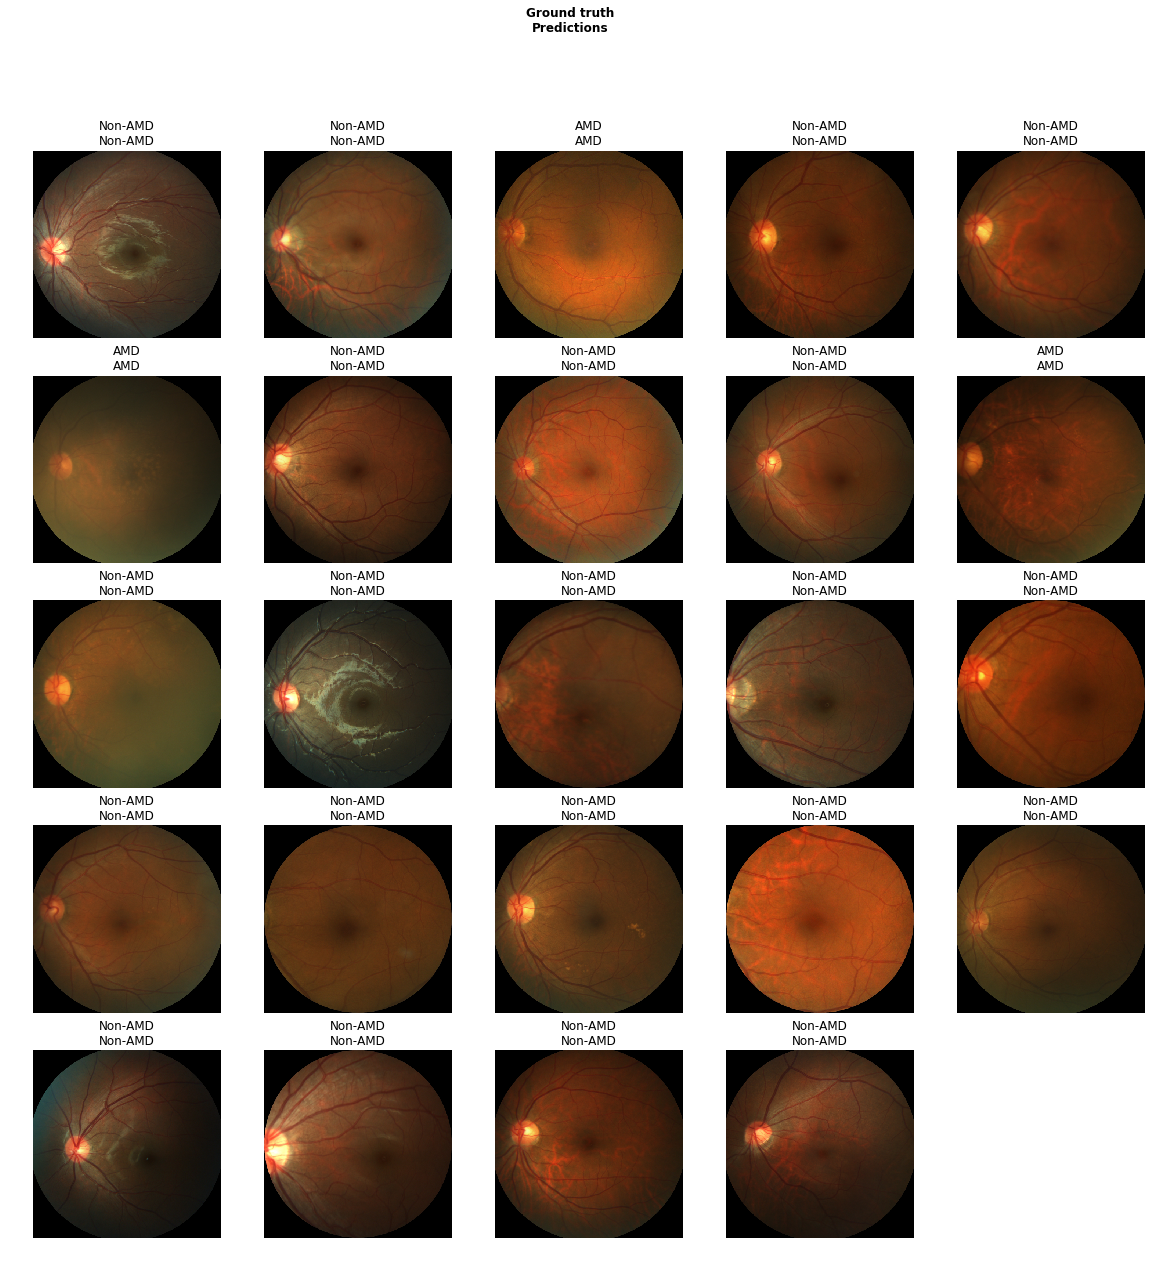

In [ ]:
learner.show_results()

#### Save Model

In [ ]:
learner.export(file='models/res50_512_classification-985acc.pkl')

In [ ]:
stage_model= 'res50_512_classification-985acc.pth'
model_file = 'res50_512_classification-985acc.pkl'
path_local_models = (train_path/'models')
model_local_path = str(path_local_models/stage_model)
# upload_files_to_gcp(model_local_path, path_ophthalmology_models)
ls_gcp(path_ophthalmology_models)

Copying file://AMD_Data/Training400/models/res50_512_classification-985acc.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/244.8 MiB.                                    
gs://medbotai/models/Ophthalmology/Age_Macular_Degeneration-models/res50_512_classification-985acc.pkl
gs://medbotai/m

In [ ]:
path

### HeatMap

In [ ]:
def heatMap(x, data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, 1].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.6, extent=size,
              interpolation='bilinear', cmap='magma')
    

Category AMD

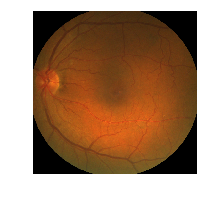

In [ ]:
x,y = data512.valid_ds[2]
x.show()
data512.valid_ds.y[2]

In [ ]:
x= Image(x.data.float())


In [ ]:
learner.to_fp32()

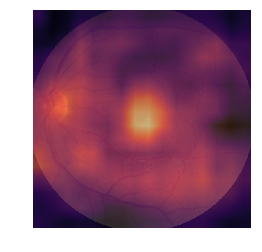

In [ ]:
heatMap(x,y,data512,learner, size=(0,512,512,0))

In [ ]:
class Inference():

    def __init__(self, path, file_name):
        """ Inference 
        :path = path to the .pkl file
        :file_name
        return: class prediction
        """
        self.learner = load_learner(path, file_name)
        self.learner.to_fp32()
        self.classes= self.learner.data.single_ds.y.classes

    def __call__(self, img, print_probs=True, heatmap=False):
        img = open_image(img) if not isinstance(
            img, fastai.vision.image.Image) else img
        pred_class, idx, probs = self.learner.predict(img)
        
        if print_probs:
          for i,p in enumerate(probs): print(f"{self.classes[i]} {(p*100):.3f}")
        if heatmap: self.show_heatmap(img)
        return pred_class, idx, probs
      
    def show_heatmap(self, img):
        heatMap(img, self.learner.data, self.learner, size=(0,512,512,0))
        plt.show()
    

In [ ]:
# path_local_models= 'AMD_Data/Training400/models/'
predict_AMD=Inference(path_local_models, model_file)

In [ ]:
img_f = (train_path/'Non-AMD').ls()[0] # non amd

 Non-AMD 100.000 
 AMD 0.000 


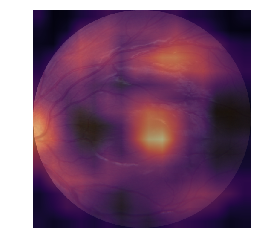

In [ ]:
pred_class, idx, probs=predict_AMD(img_f, heatmap=True)


# Segmentation

In [ ]:
img_files= get_image_files(train_path, recurse=True)
mask_files=get_image_files(ann_train_path, recurse=True)
img_files[0:3]

[PosixPath('AMD_Data/Training400/Non-AMD/N0111.jpg'),
 PosixPath('AMD_Data/Training400/Non-AMD/N0016.jpg'),
 PosixPath('AMD_Data/Training400/Non-AMD/N0144.jpg')]

In [ ]:
len(img_files), len(get_image_files(ann_train_path, recurse=True))

(400, 148)

In [ ]:
f_scar    = (ann_train_path/'scar').ls()[0]
f_exudate = (ann_train_path/'exudate').ls()[0]
f_drusen  = (ann_train_path/'drusen').ls()[0]
f_hemorrhage=(ann_train_path/'hemorrhage').ls()[0]
f_others  = (ann_train_path/'others').ls()[0]

In [ ]:
classes = ['others', 'drusen', 'scar', 'hemorrhage','exudate']

In [ ]:
def preprocess_masks(fn:Path, x:torch.Tensor)->torch.Tensor:
    x.div_(255)
    if fn.parts[-2] =='others': x[x>0]=0.2
    if fn.parts[-2] =='drusen': x[x>0]=0.4
    if fn.parts[-2] =='scar':   x[x>0]=0.6
    if fn.parts[-2] =='hemorrhage': x[x>0]=0.8
    if fn.parts[-2] =='exudate':    x[x>0]= 1.
    else: return x
    return x
      

In [ ]:
def process_img_files(img_files, mask_files):
    img_files_in_mask_files = lambda x:  [ m for m in mask_files if x.name[:-4] == m.name[:-4]]
    img_mask_dict= {img_files[i].name[:-4] : img_files_in_mask_files(img_f) 
               for i, img_f in enumerate(img_files) if img_files_in_mask_files(img_f)}
    image_files = [img_f for img_f in img_files if img_files_in_mask_files(img_f)]
    return img_mask_dict, image_files

img_dict, imf= process_img_files(img_files, mask_files)

def get_mask_path(img_f):
  try: return img_dict[img_f.name[:-4]]
  except: print('Dont have a mask ')
  



In [ ]:
get_im= lambda x: pil2tensor(PIL.Image.open(x).convert('L'), np.float32)


In [ ]:
def open_AMD_mask(fn:PathOrStr, convert_mode:str='L', cls:type=ImageSegment)->ImageSegment:
    "Return `Image` object created from image in file `fn`."
    
    get_im= lambda x: pil2tensor(PIL.Image.open(x).convert(convert_mode), np.float32)
    if len(fn)>1:
      x= torch.stack([preprocess_masks(mk, get_im(mk)) 
                      for mk in fn], dim=0).sum(0)
    else: x= preprocess_masks(fn[0], get_im(fn[0]))   
#     if True in (x>1): x.div_(x.max())
    return cls(x)

In [ ]:
img_f= (train_path/'AMD/A0002.jpg')
img_f.name[:-4]  

In [ ]:
mask = open_AMD_mask(get_mask_path(img_f))

In [ ]:
fn = get_mask_path(img_f)

if len(fn)>1:
      x= torch.stack([preprocess_masks(mk, get_im(mk)) 
                      for mk in fn], dim=0).sum(0)
else: x= preprocess_masks(fn[0], get_im(fn[0])) 
  
x.unique()

tensor([1.0000, 1.4000, 1.6000, 1.8000, 2.4000])

In [ ]:
len(x.unique()), len(fn)


In [ ]:
import torchvision
torchvision.models.segmentation.deeplabv3_resnet101??

In [ ]:
mm=ImageSegment(x)
mm.data.unique()

tensor([0, 1])

In [ ]:
m1= preprocess_masks(fn[0], get_im(fn[0]))
m2= preprocess_masks(fn[1], get_im(fn[1]))
m3= preprocess_masks(fn[2], get_im(fn[2]))


In [ ]:
ImageSegment(m1)

In [ ]:
torch.stack([m1,m2,m3],dim=0).mean(0).unique() 

tensor([1.6667, 2.3333, 2.6667, 3.0000, 4.0000])

In [ ]:
src=ImageList(im_files)
src.items

array([PosixPath('AMD_Data/Training400/Non-AMD/N0040.jpg'), PosixPath('AMD_Data/Training400/Non-AMD/N0268.jpg'),
       PosixPath('AMD_Data/Training400/Non-AMD/N0024.jpg'), PosixPath('AMD_Data/Training400/Non-AMD/N0293.jpg'), ...,
       PosixPath('AMD_Data/Training400/AMD/A0043.jpg'), PosixPath('AMD_Data/Training400/AMD/A0021.jpg'),
       PosixPath('AMD_Data/Training400/AMD/A0017.jpg'), PosixPath('AMD_Data/Training400/AMD/A0019.jpg')], dtype=object)

In [ ]:
def get_masks(x): 
  mask_file= x.name.split('.')[0]
  if x.parts[1].startswith('Training'):
    mask = 'Glaucoma/'+ mask_file if mask_file.startswith('g') else 'Non-Glaucoma/'+ mask_file
  elif 'Validation' in str(x):
    return ann_valid_path/(mask_file+'.bmp')
  return ann_train_path/(mask + '.bmp') 

In [ ]:
mask= open_mask(get_masks(image_files[0]), div=True)
mask.data.unique()

tensor([0, 1])

In [ ]:
all_images_files= image_files + valid_files
all_masks_files = masks_files + valid_masks_files

In [ ]:
class GlaucomaSegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)
  
class GlaucomaSegmentationItemList(ImageList):
  _label_cls= GlaucomaSegmentationLabelList

In [ ]:
src= (GlaucomaSegmentationItemList(all_images_files)
      .split_by_rand_pct()
      .label_from_func(get_masks, classes=classes))

def get_segmentation_data(bs, size, **kwargs):
  return (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
          .databunch(bs=bs, num_workers=0, **kwargs)
          .normalize())

In [ ]:
data= get_segmentation_data(8, 224)

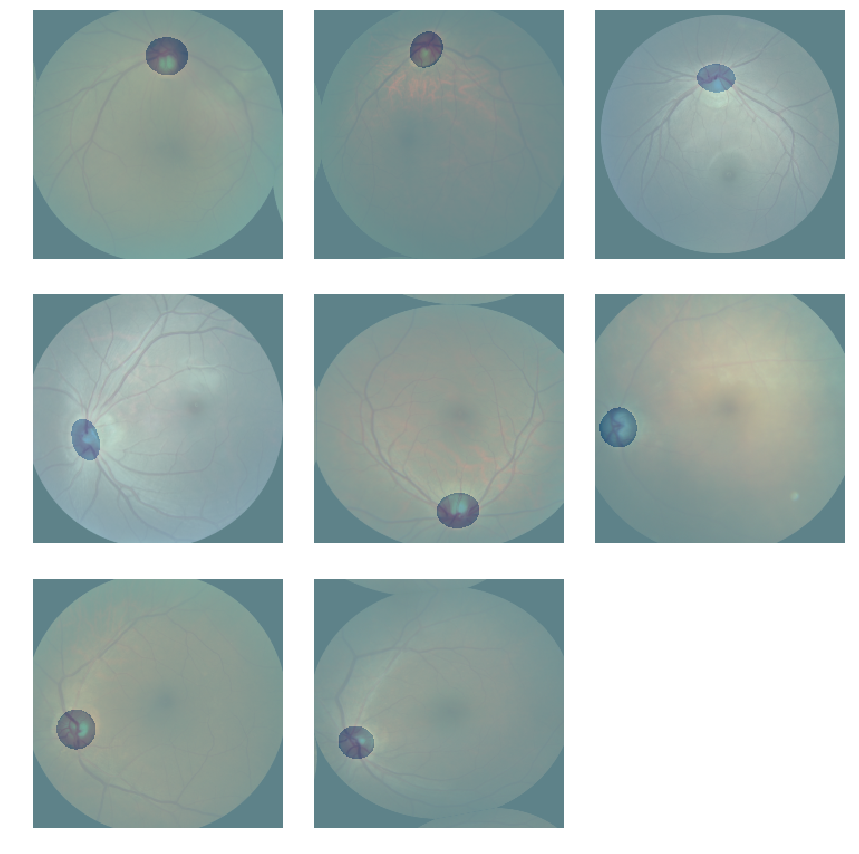

In [ ]:
data.show_batch(rows=3, alpha=0.6)

## Training

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='unet_224'),
        ShowGraph]

In [ ]:
learner = unet_learner(data, models.resnet50, metrics=[dice], callback_fns=cbfs)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


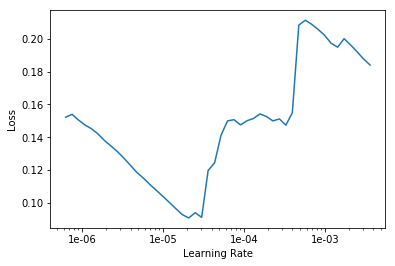

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,dice,time
0,0.031254,0.006844,0.998699,06:57
1,0.010050,0.004571,0.999015,07:09


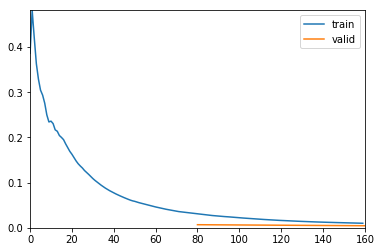

In [ ]:
lr= 1e-3
learner.fit_one_cycle(2, max_lr=slice(1e-4, lr), wd=1e-2)

In [ ]:
learner.load('unet_224_2')

In [ ]:
learner.save('unet_224-99dice')

## Evaluation

In [ ]:
interp = SegmentationInterpretation.from_learner(learner)
top_losses, top_idxs = interp.top_losses(sizes=(224,224))

In [ ]:
learner.data.classes


['Glaucoma', 'Non-Glaucoma']

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
interp._generate_confusion??

label,score
Non-Glaucoma,0.99924
Glaucoma,0.938336


,label,score
1,Non-Glaucoma,0.99924
0,Glaucoma,0.938336


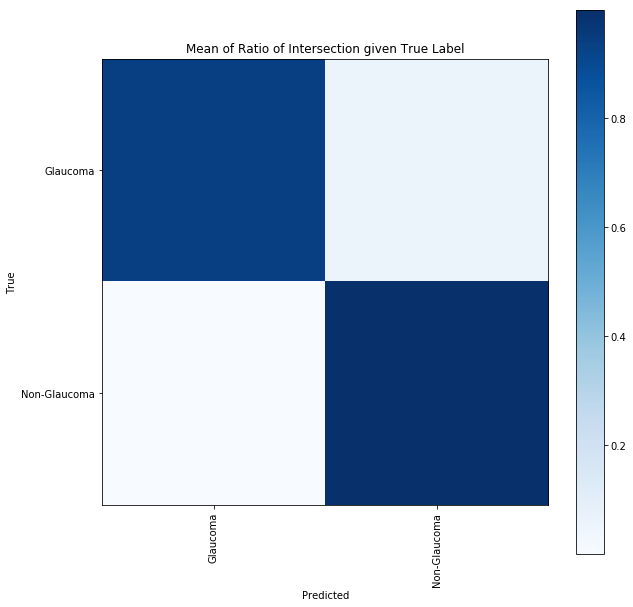

In [ ]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
df

label,score
Non-Glaucoma,1
Glaucoma,0.776688


,label,score
1,Non-Glaucoma,1
0,Glaucoma,0.776688


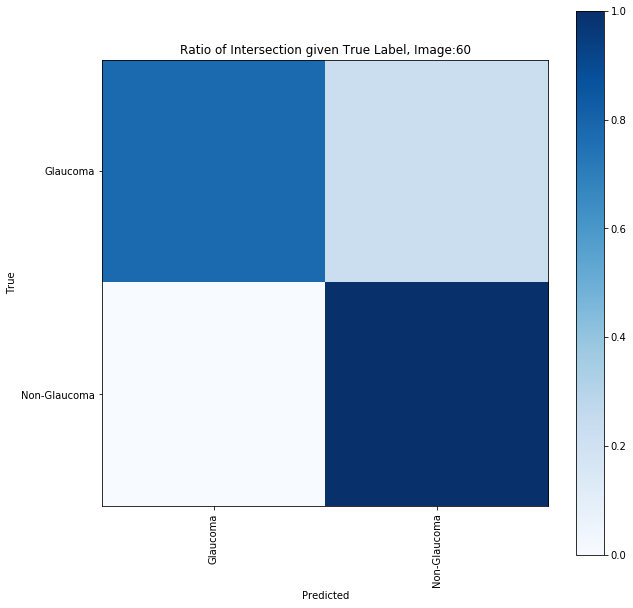

In [ ]:
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
df

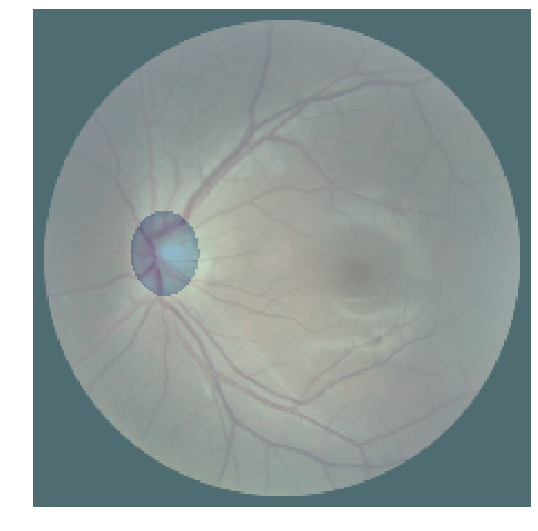

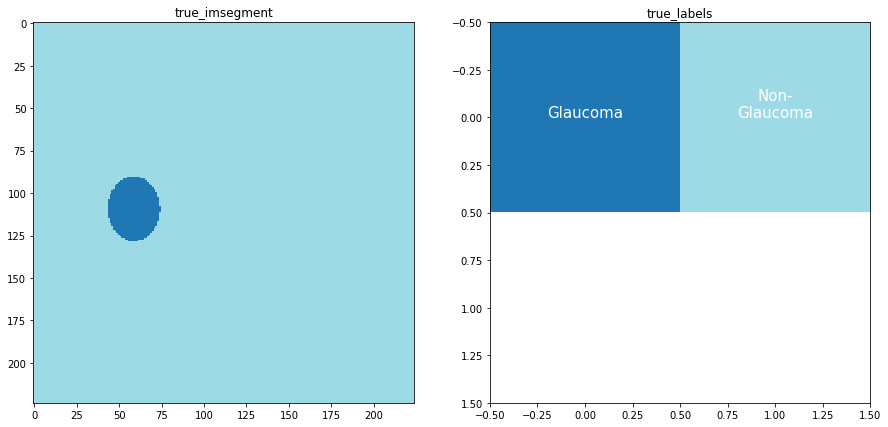

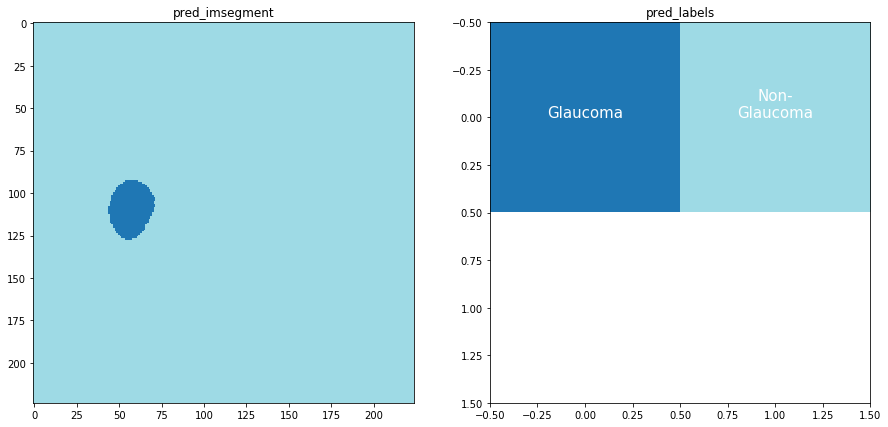

In [ ]:
interp.show_xyz(i, sz=15)

In [ ]:
learner.show_results()

#### Save Model

In [ ]:
learner.export(file='models/unet_224-99dice.pkl')

## Inference

In [ ]:
class Inference():
  def __init__(self, path, file_name): 
    """ Inference 
    :path = path to the .pkl file
    :file_name
    return: class prediction
    """
    self.learner=load_learner(path, file_name)
    self.learner.model.float()
  
  def __call__(self, img):
    img=open_image(img) if not isinstance(img,fastai.vision.image.Image ) else img
    masks= self.learner.predict(img)
    img  = self.learner.data.one_item(img)[0]
    if getattr(self.learner.data,'norm',False): img = self.learner.data.denorm(img)
    img=torch.squeeze(img, dim=0)
    image= Image(img)
    return image, masks[0]

In [ ]:
predict_img_seg= Inference(path_local_models, model_file)

In [ ]:
img = open_image(glaucoma_files[2])

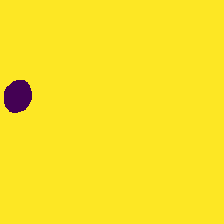

In [ ]:
image, mask_pred=predict_img_seg(img)
mask_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


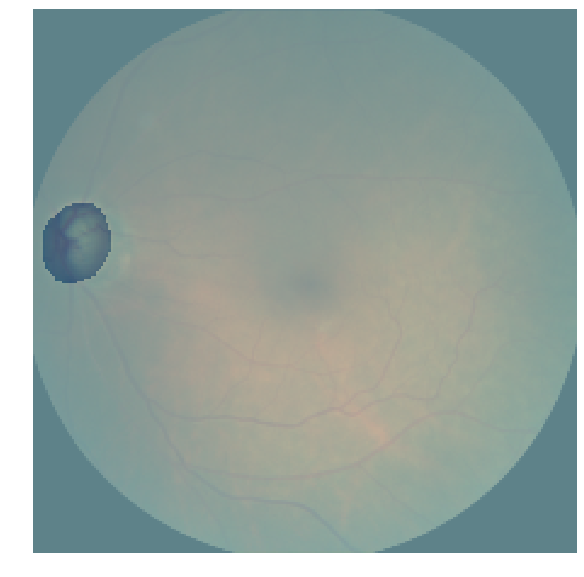

In [ ]:
image.show(y=mask_pred, figsize=(10,10), alpha=0.6)

In [ ]:
def show_mask(image: torch.Tensor, mask:torch.Tensor, alpha=0.5, cmap='tab20', figsize=(10,10)): 
    plt.figure(figsize=figsize)
    plt.imshow(image.permute(1,2,0), cmap='gray')
    plt.imshow(torch.squeeze(mask,dim=0), cmap=cmap, alpha=alpha)
    plt.grid(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


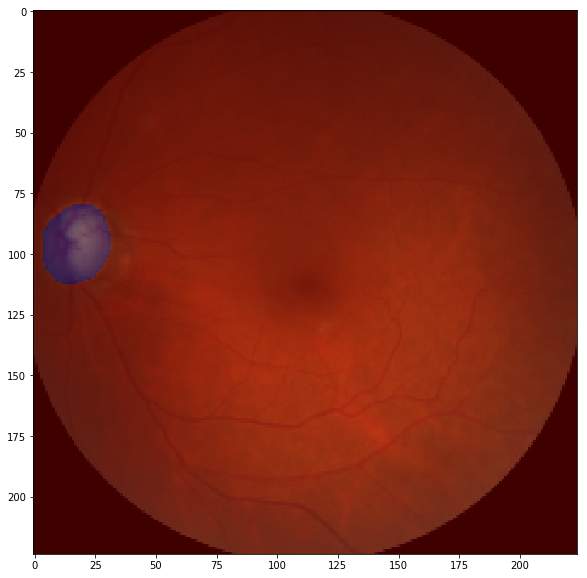

In [ ]:
show_mask(image.data, mask_pred.data, cmap='jet')